In [72]:
#Import stuff
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
#import seaborn as sns
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

In [73]:
import treecorr
import healpy as hp
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord

In [74]:
# Open and read the 2MPZ catalog
mpz_cat = fits.open('2MPZ.fits')
#mpz_cat[1].header.keys

In [75]:
# Convert to rad 
rad_to_deg = 180.0/np.pi
ra_mpz = rad_to_deg*mpz_cat[1].data['RA']
dec_mpz = rad_to_deg*mpz_cat[1].data['DEC']
z_mpz = mpz_cat[1].data['ZPHOTO']

for i in range(len(ra_mpz)):
    if (ra_mpz[i] > 150.):
        ra_mpz[i] = ra_mpz[i]-360.
        
# Keep only those in the box (-70,110)&(-70,10)
box = (ra_mpz>-70.0)&(ra_mpz<110.)&(dec_mpz>-70.0)&(dec_mpz<10.0)

ra_mpz = ra_mpz[box]
dec_mpz = dec_mpz[box]
z_mpz = z_mpz[box]

print(len(ra_mpz))

281008


Keep only those inside the healpix map

In [76]:
# ==========================================
# ==========================================
MAP = hp.read_map('y3a2_footprint_grizY_any.fits')

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [77]:
# Get a mask - 1 inside the DES mask
DES_mask = np.zeros(len(MAP))
DES_mask[MAP>0] = 1
# ======================================================
# ======================================================
# Get the healpix indices of the mpz galaxies
HP_ind = hp.ang2pix(4096, ra_mpz, dec_mpz, lonlat=True)

In [78]:
# Keep only those with randoms for which the value of the des mask 
# ===============================================
# ===============================================
# Keep local mask
LOCAL_mask = DES_mask[HP_ind]

# Keep those with LOCAL_mask = 1
ra_mpz_in = ra_mpz[LOCAL_mask==1]
dec_mpz_in = dec_mpz[LOCAL_mask==1]
z_mpz_in = z_mpz[LOCAL_mask==1]

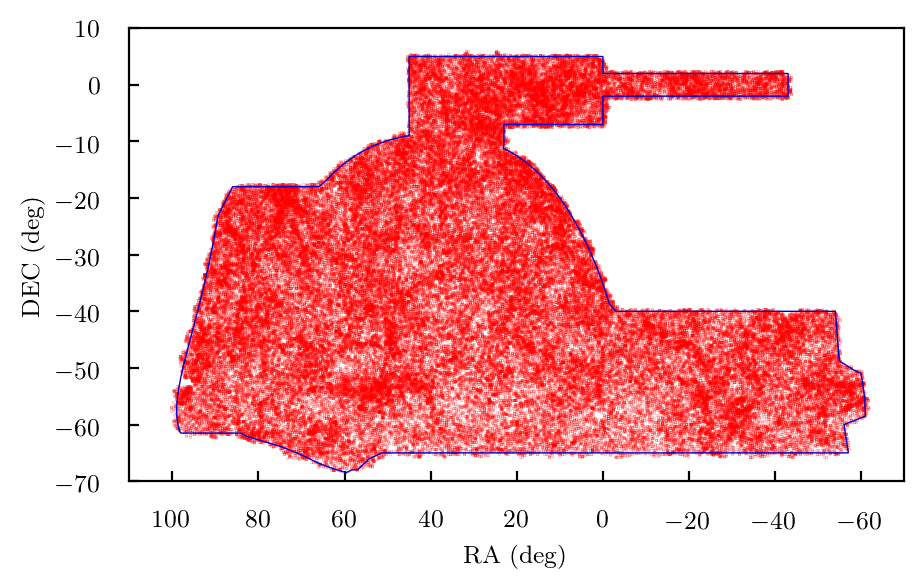

In [79]:
ra_DES, dec_DES = np.loadtxt("DES_polygon.dat", usecols=(0,1), unpack=3)

plt.figure(figsize = (5.0,3.0))        
plt.plot(ra_DES, dec_DES, c='mediumblue', linewidth=0.5)
plt.scatter(ra_mpz_in, dec_mpz_in, c='r', s=0.005)


plt.xlim(110,-70)
plt.ylim(-70,10)
plt.xlabel('RA (deg)');plt.ylabel('DEC (deg)')
plt.show()

## Calculate the two-point correlation function of the 2MPZ catalog

In [126]:
# Create catalog
cat_mpz = treecorr.Catalog(ra=ra_mpz_in, dec=dec_mpz_in, ra_units='deg', dec_units='deg')

In [127]:
dd = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.2, sep_units='degrees')
dd.process(cat_mpz)

#### Create a random catalog

Create a random catalog that covers the footprint.

In [128]:
conv = np.pi/180.
ra_min = -70.0*conv
ra_max = 110.*conv
dec_min = -70.*conv
dec_max = 10.*conv
# ========================
# ========================
rand_ra = np.random.uniform(ra_min, ra_max, 10**7)
rand_sindec = np.random.uniform(np.sin(dec_min), np.sin(dec_max), 10**7)
rand_dec = np.arcsin(rand_sindec)
# ========================

In [129]:
# Get the healpix indices of the randoms
HP_ind_rand = hp.ang2pix(4096, rand_ra/conv, rand_dec/conv, lonlat=True)

In [130]:
# Keep only those with randoms for which the value of the des mask 
# ===============================================
# ===============================================
# Keep local mask
LOCAL_mask_rand = DES_mask[HP_ind_rand]

# Keep those with LOCAL_mask = 1
rand_ra_pos = rand_ra[LOCAL_mask_rand==1]
rand_dec_pos = rand_dec[LOCAL_mask_rand==1]

In [131]:
# Let's make a catalog for the randoms
rand = treecorr.Catalog(ra=rand_ra_pos, dec=rand_dec_pos, ra_units='radians', dec_units='radians')
rr = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.2, sep_units='degrees')
rr.process(rand)

In [132]:
dr = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.2, sep_units='degrees')
dr.process(cat_mpz, rand)

In [133]:
# Calculate 2pt correlation function of the total sample
xi, varxi = dd.calculateXi(rr, dr)
r = np.exp(dd.meanlogr)
sig = np.sqrt(varxi)

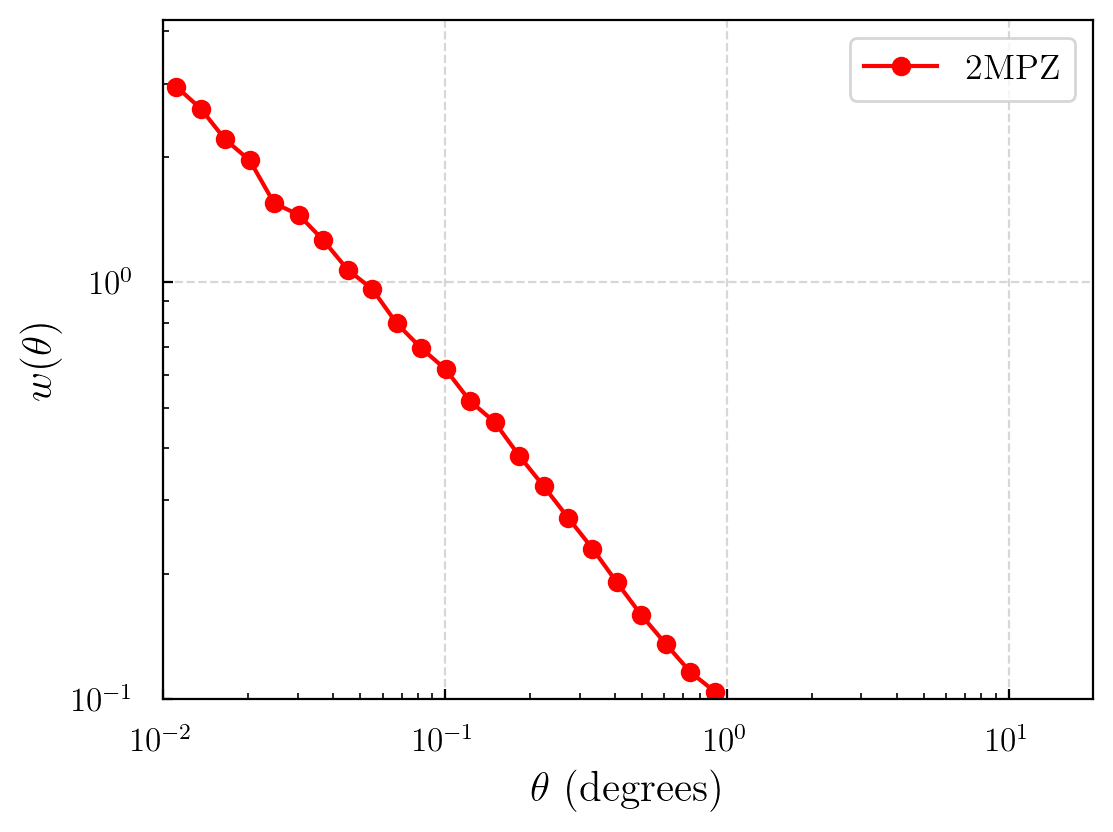

In [134]:
plt.figure(figsize = (6.0,4.5))



# All galaxies
plt.plot(r, xi, color='r',marker='o', markeredgecolor='r', label='2MPZ')
plt.plot(r, -xi, color='r',marker='o', markeredgecolor='r', ls=':')



# ============================================================
# ============================================================
plt.grid(ls='--',alpha=0.5)
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)', fontsize=15)



plt.ylabel(r'$w(\theta)$', fontsize=15)
plt.legend(frameon=True, loc='upper right', fontsize=13)
#plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,20]);plt.ylim(1.0e-1)
plt.tick_params(axis='both', labelsize=12)
plt.savefig('two_point_2.pdf', dpi=300)
plt.show()

In [135]:
# Import (and plot for visualization reasons) the coordinates of the LSBGs objects
ra, dec= np.loadtxt("LSBGs_properties_tot.dat", usecols=(1,2), unpack=3)
for i in range(len(ra)):
    if (ra[i] > 150.):
        ra[i] = ra[i]-360.
        

In [136]:
# Create catalog
cat = treecorr.Catalog(ra=ra, dec=dec, ra_units='deg', dec_units='deg')

In [137]:
dd = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.2, sep_units='degrees')
dd.process(cat)

In [138]:
dr = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.2, sep_units='degrees')
dr.process(cat, rand)

In [139]:
# Calculate 2pt correlation function of the total sample
xi_LSBG, varxi_LSBG = dd.calculateXi(rr, dr)
r_LSBG = np.exp(dd.meanlogr)
sig_LSBG = np.sqrt(varxi_LSBG)

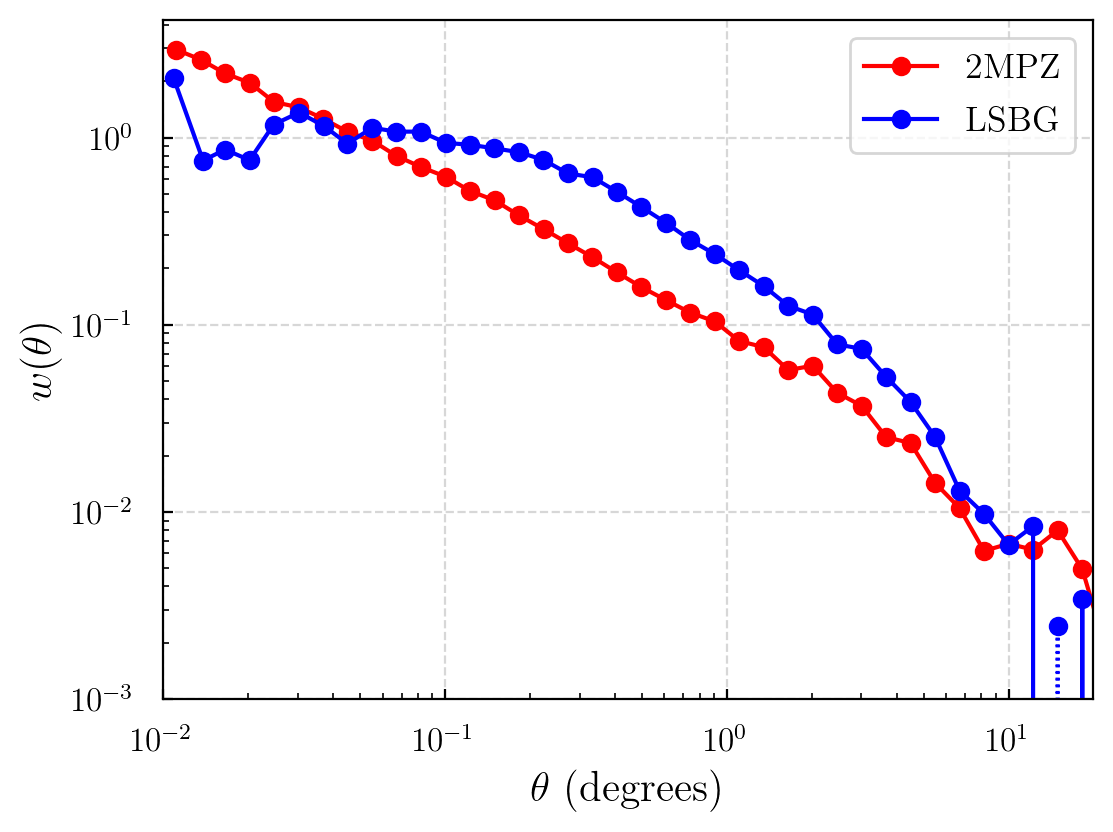

In [140]:
plt.figure(figsize = (6.0,4.5))



# All galaxies
plt.plot(r, xi, color='r',marker='o', markeredgecolor='r', label='2MPZ')
plt.plot(r, -xi, color='r',marker='o', markeredgecolor='r', ls=':')


# All galaxies
plt.plot(r_LSBG, xi_LSBG, color='b',marker='o', markeredgecolor='b', label='LSBG')
plt.plot(r_LSBG, -xi_LSBG, color='b',marker='o', markeredgecolor='b', ls=':')

# ============================================================
# ============================================================
plt.grid(ls='--',alpha=0.5)
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)', fontsize=15)



plt.ylabel(r'$w(\theta)$', fontsize=15)
plt.legend(frameon=True, loc='upper right', fontsize=13)
#plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,20]);plt.ylim(1.0e-3)
plt.tick_params(axis='both', labelsize=12)
plt.savefig('two_point_2.pdf', dpi=300)
plt.show()

### Apply a redshift cut

Keep only those with $z<0.1$.

In [189]:
ra_mpz_low = ra_mpz_in[z_mpz_in<0.04]
dec_mpz_low = dec_mpz_in[z_mpz_in<0.04]

# Create catalog
cat_low = treecorr.Catalog(ra=ra_mpz_low, dec=dec_mpz_low, ra_units='deg', dec_units='deg')

dd_low = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.2, sep_units='degrees')
dd_low.process(cat_low)

In [190]:
dr_low = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.2, sep_units='degrees')
dr_low.process(cat_low, rand)

In [191]:
# Calculate 2pt correlation function of the total sample
xi_low, varxi_low = dd_low.calculateXi(rr, dr_low)
r_low = np.exp(dd_low.meanlogr)
sig_low = np.sqrt(varxi_low)

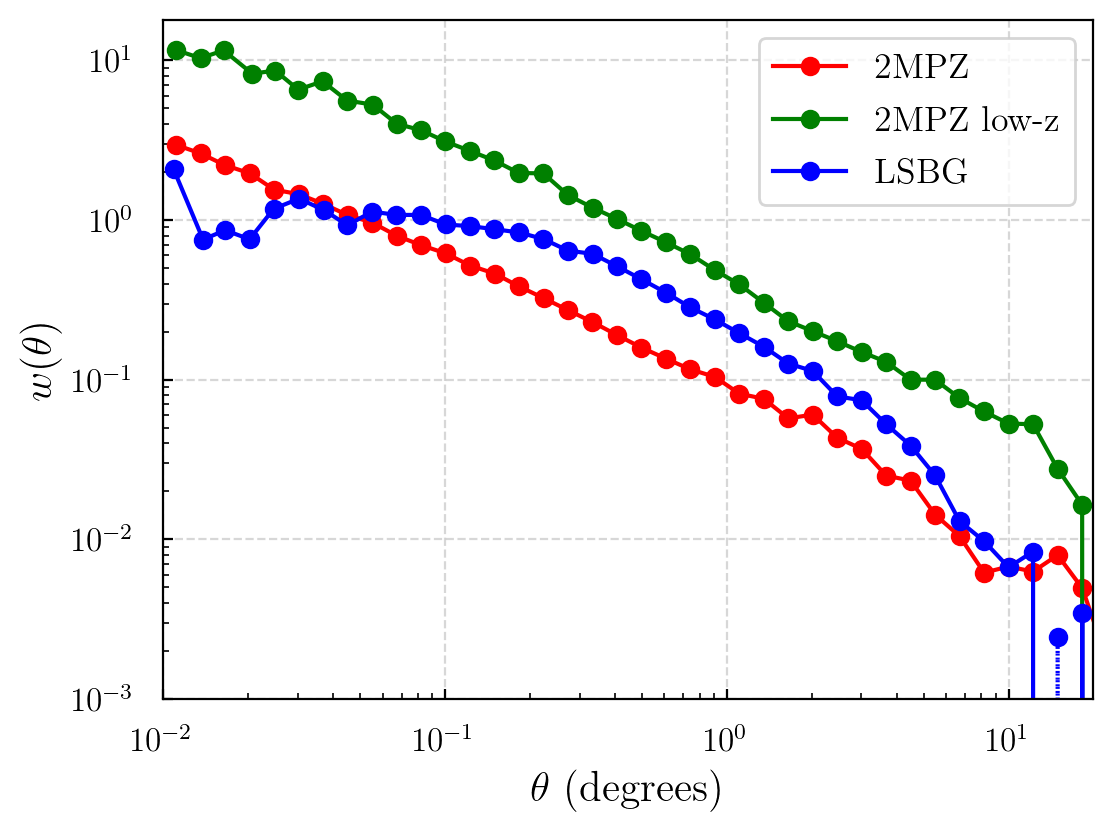

In [192]:
plt.figure(figsize = (6.0,4.5))



# All galaxies
plt.plot(r, xi, color='r',marker='o', markeredgecolor='r', label='2MPZ')
plt.plot(r, -xi, color='r',marker='o', markeredgecolor='r', ls=':')

# All galaxies
plt.plot(r_low, xi_low, color='g',marker='o', markeredgecolor='g', label='2MPZ low-z')
plt.plot(r_low, -xi_low, color='g',marker='o', markeredgecolor='g', ls=':')


# All galaxies
plt.plot(r_LSBG, xi_LSBG, color='b',marker='o', markeredgecolor='b', label='LSBG')
plt.plot(r_LSBG, -xi_LSBG, color='b',marker='o', markeredgecolor='b', ls=':')

# ============================================================
# ============================================================
plt.grid(ls='--',alpha=0.5)
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)', fontsize=15)



plt.ylabel(r'$w(\theta)$', fontsize=15)
plt.legend(frameon=True, loc='upper right', fontsize=13)
#plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,20]);plt.ylim(1.0e-3)
plt.tick_params(axis='both', labelsize=12)
plt.savefig('two_point_2.pdf', dpi=300)
plt.show()

In [193]:
print(np.mean(z_mpz_in[z_mpz_in<0.1]))

0.06666004
